# Table of Contents

<ol class="toc-item"><li><a href="#Table-of-Contents">Table of Contents</a></li><li><a href="#Prepare-&amp;-Configure-Data">Prepare &amp; Configure Data</a><ol class="toc-item"><li><a href="#Collect-latest-data-from-GitHub">Collect latest data from GitHub</a></li><li><a href="#Clean-data">Clean data</a><ol class="toc-item"><li><a href="#Drop-unnecessary-columns-and-rows">Drop unnecessary columns and rows</a></li><li><a href="#Create-an-Integer-ID-column-and-mapper">Create an Integer ID column and mapper</a></li></ol></li><li><a href="#Transform-table-into-list-of-lists">Transform table into list of lists</a></li><li><a href="#Create-other-constants-&amp;-data-structures">Create other constants &amp; data structures</a></li></ol></li><li><a href="#Analyze-Data">Analyze Data</a><ol class="toc-item"><li><a href="#How-many-story-instances-are-in-each-manuscript?">How many story instances are in each manuscript?</a></li><li><a href="#How-often-does-each-Story-ID-appear?">How often does each Story ID appear?</a></li><li><a href="#What-is-the-distribution-of-the-Levenshtein-edit-distance?">What is the distribution of the Levenshtein edit distance?</a></li><li><a href="#Story-ID's-neighbors">Story ID's neighbors</a><ol class="toc-item"><li><a href="#What-IDs-are-most-commonly-first-and-last-in-a-manuscript?">What IDs are most commonly first and last in a manuscript?</a></li><li><a href="#Collocation-matrices">Collocation matrices</a></li></ol></li><li><a href="#Can-we-categorize-the-different-permutations?">Can we categorize the different permutations?</a></li><li><a href="#What-are-the-most-popular-sequences-of-length-K?">What are the most popular sequences of length K?</a></li><li><a href="#Where-does-each-story-fall-within-the-manuscript?">Where does each story fall within the manuscript?</a></li></ol></li></ol>

In [2]:
import json
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

---
# Prepare & Configure Data 

## Collect latest data from GitHub

In [3]:
url = 'https://raw.githubusercontent.com/Princeton-CDH/pemm-data/master/data/story_instance.csv'
df_s = pd.read_csv(url)

In [4]:
OUTPUT_DIR = 'output'
DATA_STRUCTURE_DIR = os.path.join(OUTPUT_DIR, 'data_structures')
PLOT_DIR = os.path.join(OUTPUT_DIR, 'all_plots')
SEQUENCE_DIR = os.path.join(OUTPUT_DIR, 'sequence_data')

if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)
if not os.path.exists(DATA_STRUCTURE_DIR):
    os.makedirs(DATA_STRUCTURE_DIR)
if not os.path.exists(SEQUENCE_DIR):
    os.makedirs(SEQUENCE_DIR)

## Clean data

### Drop unnecessary columns and rows

In [5]:
print(f'Original number of rows: {df_s.shape[0]}')
df_s = df_s[['Manuscript', 'Canonical Story ID', 'Miracle Number', 'Canonical Story Title']]
df_s = df_s.dropna()
print(f'New number of rows after NaNs dropped: {df_s.shape[0]}')

Original number of rows: 10298
New number of rows after NaNs dropped: 4604


### Create an Integer ID column and mapper

Parsing and sorting the strings in `Canonical Story ID` is difficult because of their naming convention. Here we develop a continuous, unique integer ID that is useful for analysis

In [6]:
# create an integer ID that is easier than Canonical Story ID to sort and parse
sorted_strings = sorted(df_s['Canonical Story ID'].unique().tolist())
sorted_ints = sorted(sorted_strings, key=lambda x: int(x.split('-')[0]) if 'L' not in x else 600)
int_id_mapper = {s: i for i, s in enumerate(sorted_ints)}
reverse_id_mapper = {s: i for i, s in int_id_mapper.items()}

df_s['Integer ID'] = df_s['Canonical Story ID'].apply(lambda x: int_id_mapper[x]).astype('int64')
df_s.sample(5)

,Manuscript,Canonical Story ID,Miracle Number,Canonical Story Title,Integer ID
1459,BOr (BL) 520,163,5.0,The Muslim whom Saint Mary told to receive bap...,171
3312,EMIP (EMIP) 601,279,91.0,Zärˀa Yaˁəqob miracles: The inhabitants of Dam...,287
66,EMML (HMML) 6835,84,67.0,Homily of John Chrysostom on the visit of Sain...,91
4032,EMML (HMML) 2058,23,23.0,"The two blessed monks, Sadaqā and ʾƎstifānos, ...",24
3403,EMIP (EMIP) 601,330,181.0,The punishment of an Ethiopian woman who swore...,339


In [7]:
df_t = pd.DataFrame([[k, v] for (k, v) in int_id_mapper.items()], columns=['Canonical Story ID', 'Integer ID'])
df_t.to_csv(os.path.join(DATA_STRUCTURE_DIR, 'integer-id-mapper.csv'), index=False)

## Transform table into list of lists

A useful data structure in the following form:

```
all_manuscripts = [
    [1, 2, 3, ...],
    [1, 2, 3, 4, 5, ...],
    [2, 1, 4, 5, 10, 15, ...],
    [10, 2, 4, 5, 6, 3, 7, ...],
    [8, 9, 11, 2, 1, ...],
    [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, ...], 
    [11, 2, 12, 8, 13, 15, 14, ...]
]
```

In [44]:
all_manuscripts = []
all_manuscript_names = []
for i, df in df_s.groupby('Manuscript'):
    df = df.sort_values('Miracle Number')
    all_manuscripts.append(df['Integer ID'].tolist())
    all_manuscript_names.append(df['Manuscript'].unique()[0])

In [9]:
with open(os.path.join(DATA_STRUCTURE_DIR, 'all-manuscripts.json'), 'w') as f:
    json.dump(all_manuscripts, f, indent=4)

## Create other constants & data structures

In [10]:
all_ids = []
for man in all_manuscripts:
    all_ids.extend(man)

N = max(all_ids)
unique_ids = set(all_ids)

---
# Analyze Data

## How many story instances are in each manuscript?

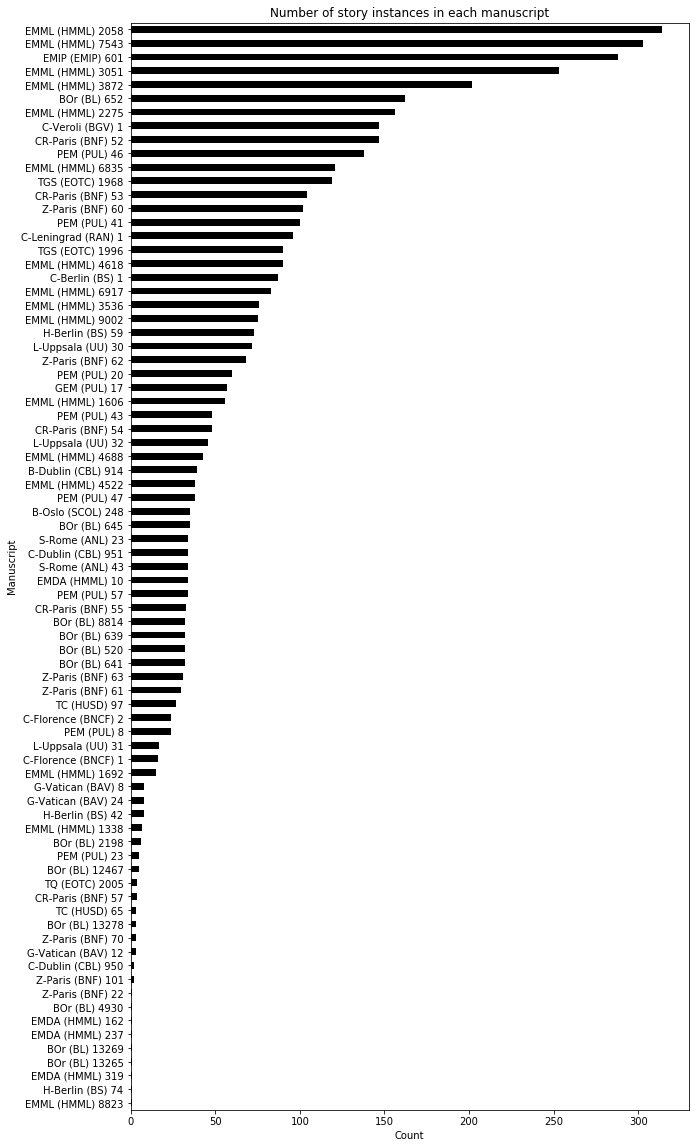

In [11]:
ax = (
    df_s.groupby('Manuscript')['Integer ID']
        .count()
        .sort_values()
        .plot(kind='barh', figsize=(10, 20), color='k')
)

ax.set_title('Number of story instances in each manuscript')
ax.set_ylabel('Manuscript')
ax.set_xlabel('Count')
plt.savefig(os.path.join(PLOT_DIR, 'story-instances-per-manuscript.png'))

## How often does each Story ID appear?

In [12]:
def get_story_name(df, story_id):
    return df[df['Canonical Story ID'] == story_id]['Canonical Story Title'].unique().tolist()[0]

popular_stories = df_s['Canonical Story ID'].value_counts()[:10]

print('Top 10 Most Frequent Stories\n')
for i, (story_id, count) in enumerate(popular_stories.iteritems()):
    story_name = get_story_name(df_s, story_id)
    print(f'\t#{i+1}\n\tStory ID: {story_id}\n\tCount: {count}\n\t{story_name}\n')

Top 10 Most Frequent Stories

	#1
	Story ID: 142
	Count: 58
	The deacon's prayer that contained five times "Rejoice!" [tafassehiyat].

	#2
	Story ID: 140
	Count: 51
	The sinful deacon whom his enemies could not kill until he had confessed himself to a priest.

	#3
	Story ID: 163
	Count: 51
	The Muslim whom Saint Mary told to receive baptism. Later, as Bishop of Rome, he cut off his hand because of a carnal thought.

	#4
	Story ID: 13
	Count: 50
	The composition of the Miracles of Mary by Bishop Hildephonsus of Toledo.

	#5
	Story ID: 154
	Count: 48
	The two women who were attacked by robbers on their way to church.

	#6
	Story ID: 187
	Count: 47
	The peasant who complained to Saint Mary because she did not reply to his Hail Mary.

	#7
	Story ID: 153
	Count: 47
	The young man who used to bring roses to the icon of Saint Mary.

	#8
	Story ID: 125
	Count: 47
	The story of the cannibal from Qemer.

	#9
	Story ID: 162
	Count: 45
	The pious monk scribe who used to write Saint Mary's name in 

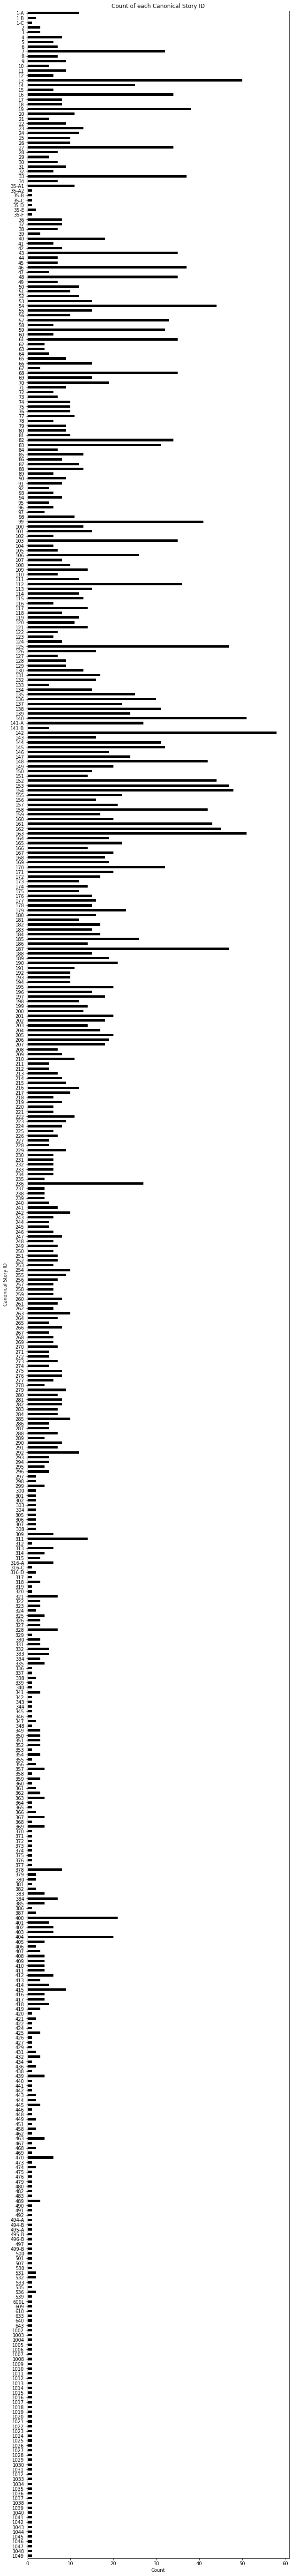

In [41]:
m = df_s['Canonical Story ID'].value_counts()

# NOTE: Pandas does not support custom sort functions, so a separate dataframe was necessary
df_t = pd.DataFrame(m)
df_t['t'] = df_t.index
df_t['Integer ID'] = df_t['t'].apply(lambda x: int_id_mapper[x])
df_t = df_t[['Canonical Story ID', 'Integer ID']]

ax = (
    df_t
        .sort_values(by='Integer ID')['Canonical Story ID']
        .plot(kind='barh', color='k', figsize=(10, 100))
)

ax.set_title('Count of each Canonical Story ID')
ax.set_xlabel('Count')
ax.set_ylabel('Canonical Story ID')
ax.invert_yaxis()
plt.savefig(os.path.join(PLOT_DIR, 'canonical-story-id-count.png'))

## What are the Levenshtein edit distances between manuscripts?

[Learn more about the  Levenshtein edit distance](https://en.wikipedia.org/wiki/Levenshtein_distance)

In [13]:
def contiguous(l):
    return list(range(min(l), max(l)+1))

def levenshteinDistance(s1, s2):
    # this was copy-and-pasted from stack overflow, better review is needed
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [15]:
ld = [[levenshteinDistance(man1, man2) for man2 in all_manuscripts] for man1 in all_manuscripts]

,1-A,1-B,1-C,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0,13,36,39,38,39,38,39,13,13,...,115,85,39,38,39,69,16,65,38,39
1,13,0,32,35,35,35,34,35,7,7,...,115,85,35,35,34,73,10,66,34,33
2,36,32,0,5,5,5,6,5,29,29,...,119,90,5,5,5,99,27,67,30,5
3,39,35,5,0,1,3,6,1,32,32,...,118,89,4,2,1,101,30,68,31,3
4,38,35,5,1,0,3,6,1,32,32,...,119,89,4,2,1,102,30,68,31,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,69,73,99,101,102,100,99,102,70,70,...,115,99,102,100,101,0,73,97,97,100
75,16,10,27,30,30,30,30,30,3,3,...,117,85,30,30,30,73,0,66,30,30
76,65,66,67,68,68,68,66,68,65,65,...,115,87,68,68,68,97,66,0,37,67
77,38,34,30,31,31,31,30,31,30,30,...,116,87,31,31,31,97,30,37,0,31


In [25]:
i = 0
j = 3
df_ld.iloc[i, j]

39

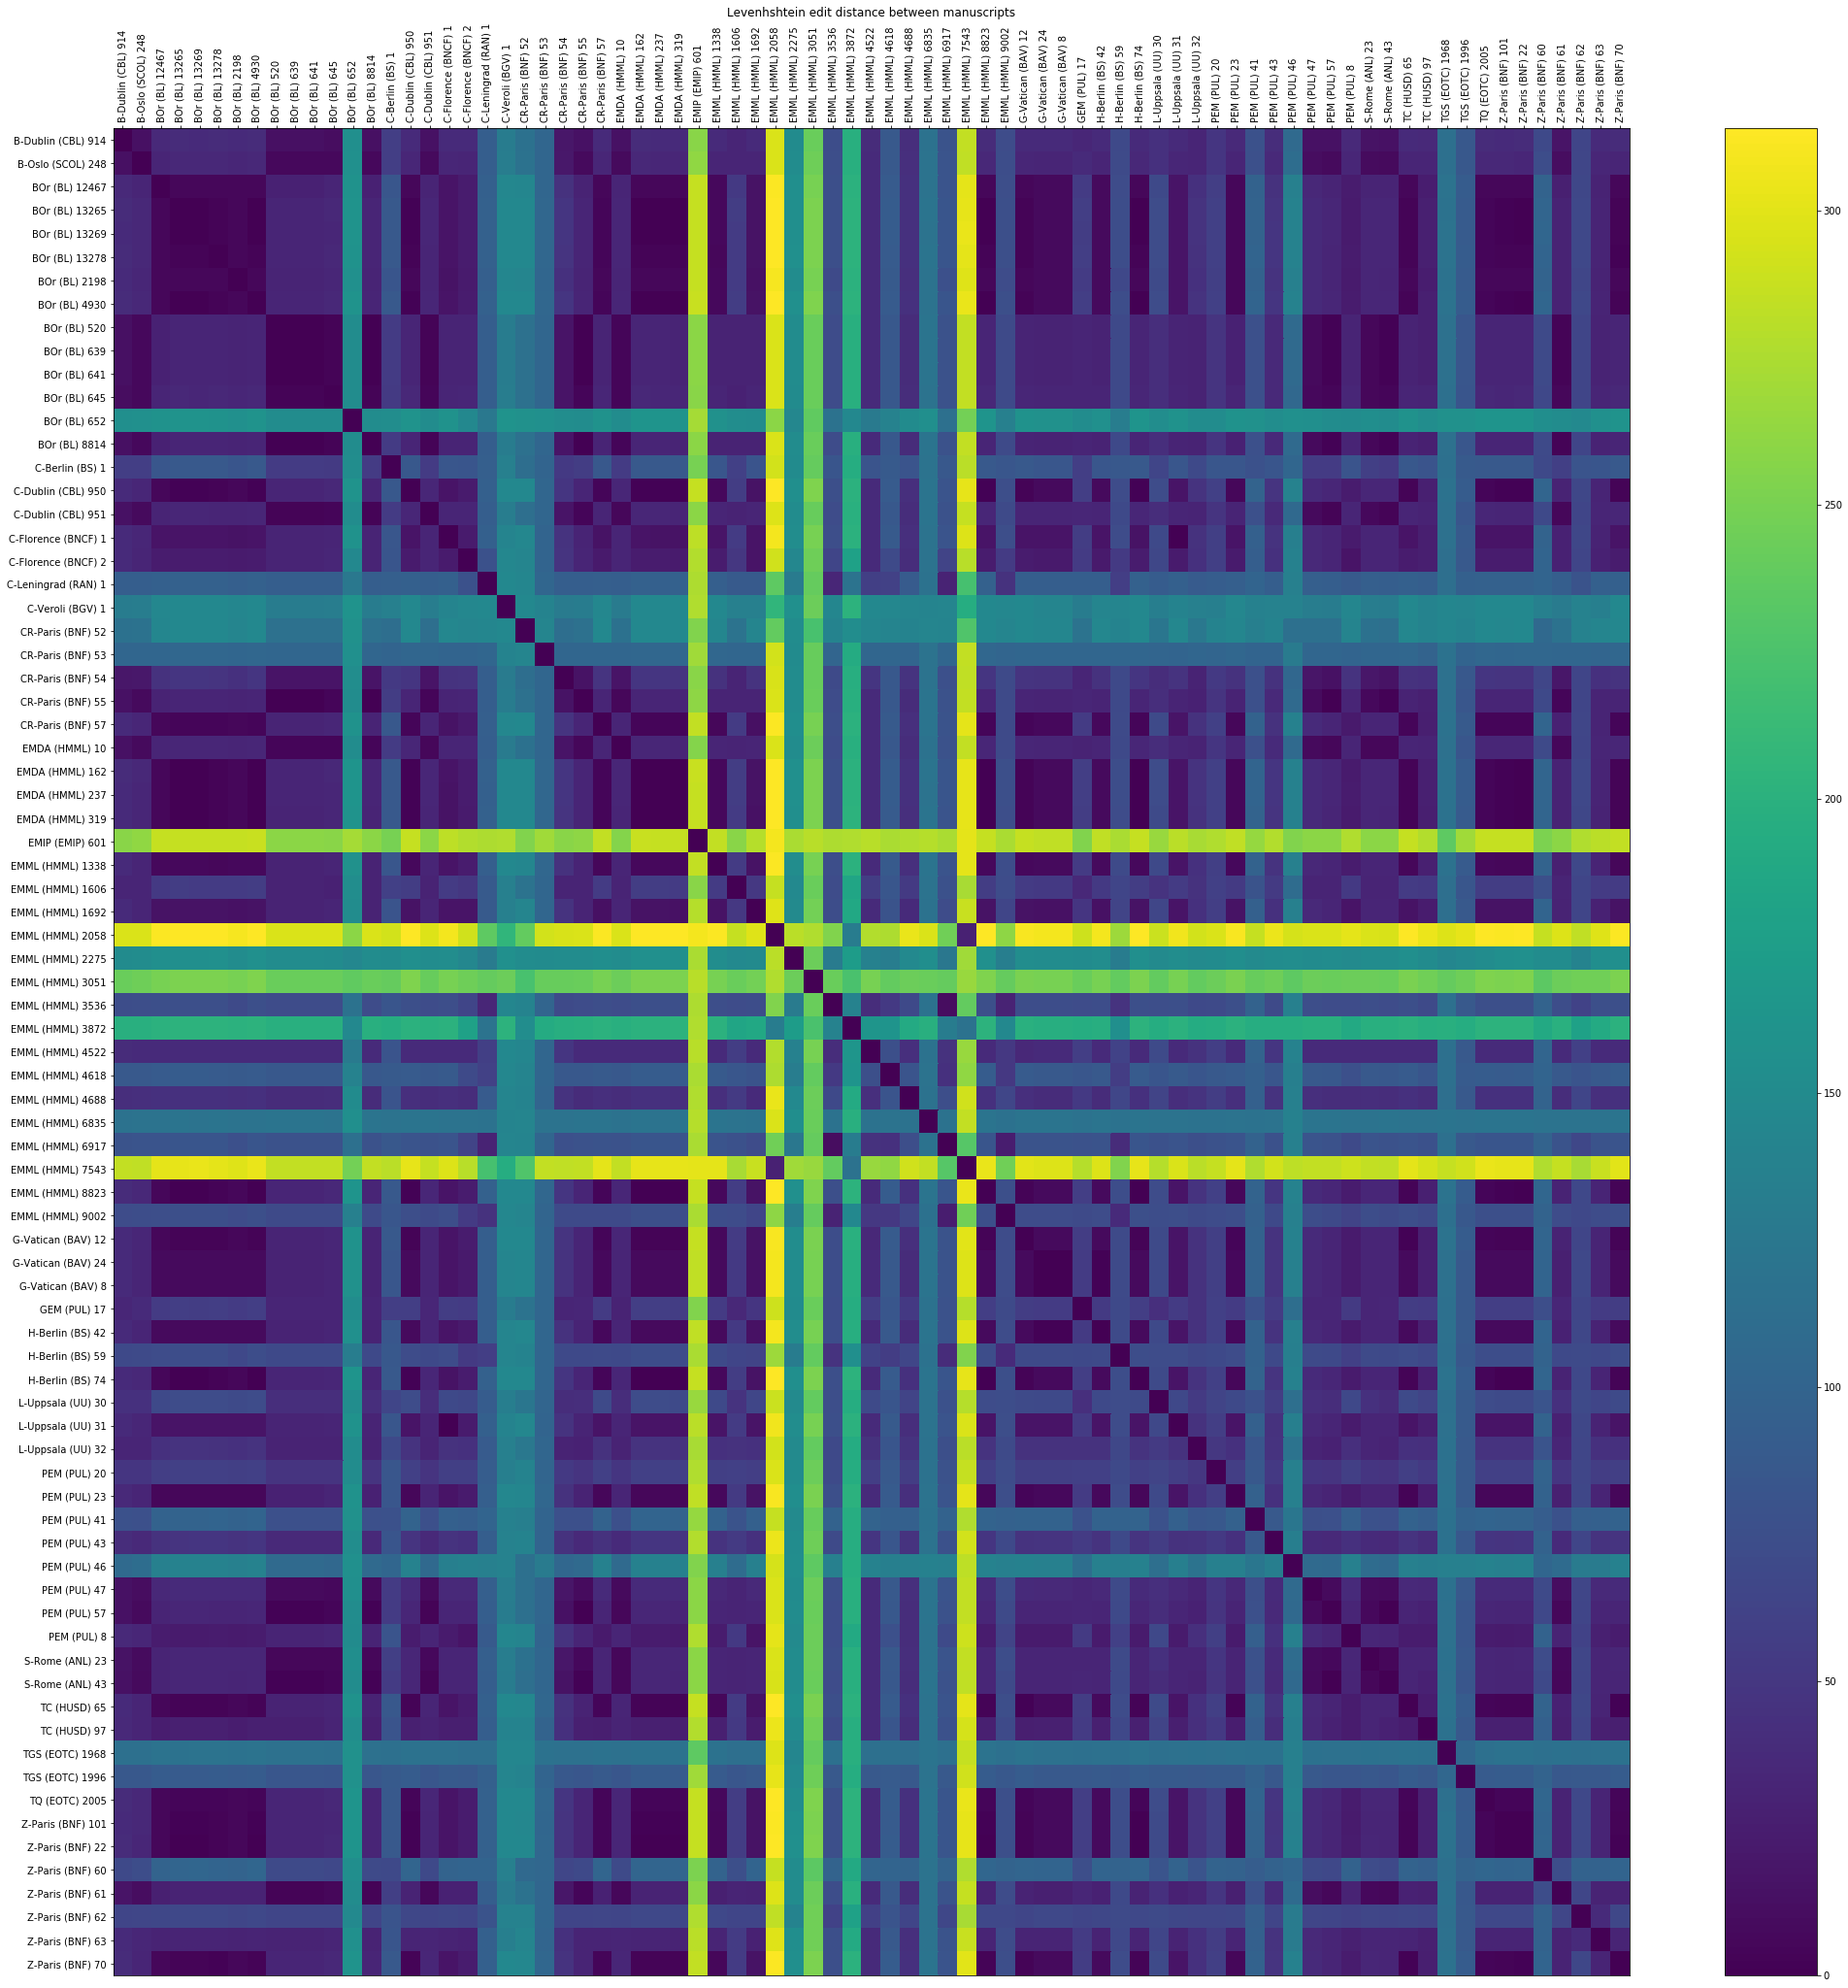

In [48]:
axes = [all_manuscript_names[i] for i, x in enumerate(all_manuscripts)]
df_ld = pd.DataFrame(ld, columns=axes, index=axes)
plt.figure(figsize=(35, 35))

plt.pcolor(df_ld)
        
plt.colorbar()
plt.xticks(np.arange(0.5, df_ld.shape[0], 1), axes, rotation=90)
plt.yticks(np.arange(0.5, df_ld.shape[0], 1), axes)
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()

plt.title('Levenhshtein edit distance between manuscripts')
plt.savefig(os.path.join(PLOT_DIR, 'levenhshtein-heatmap.png'))

## Story ID's neighbors
A colocation json is created to analyze a story ID's most frequent neighbors

In [44]:
neighbor_d = {x: {'before': [], 'after': []} for x in unique_ids}
for man in all_manuscripts:
    for i, story_id in enumerate(man):
        if i == 0:
            neighbor_d[story_id]['before'].append('F')
            if len(man) != 1:
                neighbor_d[story_id]['after'].append(man[i+1])
            else:
                neighbor_d[story_id]['after'].append('L')
        elif i == len(man)-1:
            neighbor_d[story_id]['before'].append(man[i-1])
            neighbor_d[story_id]['after'].append('L')
        else:
            neighbor_d[story_id]['before'].append(man[i-1])
            neighbor_d[story_id]['after'].append(man[i+1])

with open(os.path.join(SEQUENCE_DIR, 'collocation.json'), 'w') as f:
    json.dump(neighbor_d, f)

### What IDs are most commonly first and last in a manuscript?

In [54]:
first_count = []
for x, d in neighbor_d.items():
    first_count.append([x, d['before'].count('F')])
df_fc = pd.DataFrame(first_count, columns=['ID', 'Count'])
df_fc['Canonical Story ID'] = df_fc['ID'].apply(lambda x: reverse_id_mapper[x])
df_fc = df_fc.sort_values('Count', ascending=False) 

df_fc = df_fc[df_fc['Count'] > 1]
df_fc['Canonical Story Title'] = df_fc['Canonical Story ID'].apply(lambda x: get_story_name(df_s, x))

print('Stories that appear first more than once:')
for i,(_, r) in enumerate(df_fc.iterrows()):
    print(f"\t#{i+1}\n\tStory ID: {r['Canonical Story ID']}\n\tCount: {r['Count']}\n\t{r['Canonical Story Title']}\n")

Stories that appear first more than once:
	#1
	Story ID: 13
	Count: 37
	The composition of the Miracles of Mary by Bishop Hildephonsus of Toledo.

	#2
	Story ID: 14
	Count: 4
	The composition of the Wǝddāse Maryam by the Syrian potter.

	#3
	Story ID: 207
	Count: 4
	The monk who saved the church of Saint Mary in Atrib by his prayers when its destruction had been ordered by the Caliph.

	#4
	Story ID: 106
	Count: 3
	The rich man who threw dry bread to a beggar in the name of Saint Mary.

	#5
	Story ID: 400
	Count: 3
	The five sorrows of Saint Mary.

	#6
	Story ID: 489
	Count: 2
	Ark of Zion cycle: The beginning of the history of the Ark of Zion in the giving of the Ten Commandments.

	#7
	Story ID: 187
	Count: 2
	The peasant who complained to Saint Mary because she did not reply to his Hail Mary.



In [46]:
last_count = []
for x, d in neighbor_d.items():
    last_count.append([x, d['after'].count('L')])
df_lc = pd.DataFrame(last_count, columns=['ID', 'Count'])
df_lc['Canonical Story ID'] = df_lc['ID'].apply(lambda x: reverse_id_mapper[x])
df_lc = df_lc.sort_values('Count', ascending=False) 

df_lc = df_lc[df_lc['Count'] > 1]
df_lc['Canonical Story Title'] = df_lc['Canonical Story ID'].apply(lambda x: get_story_name(df_s, x))

print('Stories that appear last more than once:\n')
for i,(_, r) in enumerate(df_lc.iterrows()):
    print(f"\t#{i+1}\n\tCanonical Story ID: {r['Canonical Story ID']}\n\tCount: {r['Count']}\n\t{r['Canonical Story Title']}\n")

Stories that appear last more than once:

	#1
	Canonical Story ID: 236
	Count: 5
	Saint Mary gives a thirsty dog water to drink from her shoe.

	#2
	Canonical Story ID: 400
	Count: 5
	The five sorrows of Saint Mary.

	#3
	Canonical Story ID: 125
	Count: 3
	The story of the cannibal from Qemer.

	#4
	Canonical Story ID: 292
	Count: 3
	Däbrä Metmaq miracles: Saint Mary shows those assembled at Däbrä Metmaq a negative vision of Mohammad

	#5
	Canonical Story ID: 54
	Count: 2
	Saint Mary carries a dying monk to Jerusalem.

	#6
	Canonical Story ID: 148
	Count: 2
	The pregnant woman who was caught by the tide while going to the church of Saint Michael (Mont Saint Michel)

	#7
	Canonical Story ID: 309
	Count: 2
	Saint Mary appears to an official who kidnapped a girl that had made a vow of virginity.

	#8
	Canonical Story ID: 311
	Count: 2
	A stream runs uphill after his neighbor had diverted it.

	#9
	Canonical Story ID: 14
	Count: 2
	The composition of the Wǝddāse Maryam by the Syrian potter

### Collocation matrices
Percent of time an ID precedes or follows another story. 

In [47]:
def perc(map_dict, i, c):
    l = map_dict.get(i, [])
    return np.nan if len(l) == 0 else round(l.count(c)/len(l)*100, 2)

before_map = {x: d['before'] for x, d in neighbor_d.items()}
after_map = {x: d['after'] for x, d in neighbor_d.items()}

df_b = pd.DataFrame(columns=['F'] + list(range(N)), index=range(N))
for c in df_b.columns:
    df_b[c] = [perc(before_map, i, c) for i in df_b.index]

df_a = pd.DataFrame(columns=list(range(N)) + ['L'], index=range(N))
for c in df_a.columns:
    df_a[c] = [perc(after_map, i, c) for i in df_a.index]

In [48]:
df_b.to_csv(os.path.join(SEQUENCE_DIR, 'collocation-before.csv'), index=False)
df_a.to_csv(os.path.join(SEQUENCE_DIR, 'collocation-after.csv'), index=False)

## Can we categorize the different permutations?

Currently we have:
* Sorted: meaning that the IDs are in order
* Reordered: meaning that the IDs, if sorted, would be contiguous
* Contiguous: they follow the order of Canonical IDs

Ideally we'd want the "Other" category to be as low as possible, so other unique categorizations are welcome.

In [49]:
def is_sorted(l):
    # e.g. 1-2-3-10-15
    return (sorted(l) == l)

def is_reordered(l):
    # e.g. 1-2-3-5-4
    return (sorted(l) == contiguous(l)) and not l == contiguous(l)

def is_contiguous(l):
    # e.g. 1-2-3-4-5
    return contiguous(l) == l

def get_perc(j, func):
    return round(len([1 for man in j if func(man)])/len(j)*100, 2)

{'Sorted': 16.46, 'Contiguous': 12.66, 'Reordered': 0.0, 'Other': 70.88}

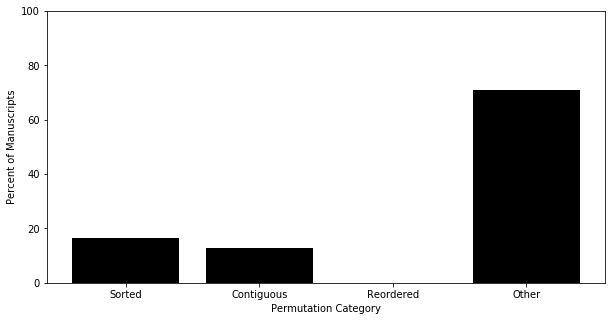

In [50]:
alteration_type = {
    'Sorted': get_perc(all_manuscripts, is_sorted),
    'Contiguous': get_perc(all_manuscripts, is_contiguous),
    'Reordered': get_perc(all_manuscripts, is_reordered)
}

alteration_type['Other'] = 100 - sum(alteration_type.values())

plt.figure(figsize=(10, 5))
plt.bar(alteration_type.keys(), alteration_type.values(), color='k')
plt.ylim((0, 100))
plt.xlabel('Permutation Category')
plt.ylabel('Percent of Manuscripts')
plt.savefig(os.path.join(PLOT_DIR, 'permutation-category.png'))
alteration_type

## What are the most popular sequences of length K?

Use the integer IDs to create a dictionary of the form ```{"#-#-#-...": count}```

Then convert to the Canonical IDs and create a table from the dictionary.

In [51]:
K = 10

In [95]:
sequence_count = {}
for man in all_manuscripts:
    if len(man) > K:
        for i, story_id in enumerate(man[:-K]):
            seq = man[i:i+K]
            assert len(seq) == K, "Something's gone wrong"
            seq_string = '-'.join([str(x) for x in seq])
            sequence_count[seq_string] = sequence_count.get(seq_string, 0) + 1
    elif len(man) == K:
        seq = man
        seq_string = '-'.join([str(x) for x in seq])
        sequence_count[seq_string] = sequence_count.get(seq_string, 0) + 1

sequence_count_list = [[[reverse_id_mapper[int(x)] for x in seq.split('-')], c] for seq, c in sequence_count.items()]

df_sc = pd.DataFrame(sequence_count_list, columns=['Sequence', 'Count'])
df_sc = df_sc.sort_values('Count', ascending=False)
df_sc.to_csv(os.path.join(SEQUENCE_DIR, f'{K}-gram-count.csv'))
df_sc.head(15)

,Sequence,Count
35,"[33, 54, 153, 154, 16, 46, 43, 48, 59, 57]",24
33,"[19, 27, 33, 54, 153, 154, 16, 46, 43, 48]",23
10,"[43, 48, 59, 57, 61, 68, 82, 83, 99, 103]",23
34,"[27, 33, 54, 153, 154, 16, 46, 43, 48, 59]",23
36,"[54, 153, 154, 16, 46, 43, 48, 59, 57, 61]",23
9,"[46, 43, 48, 59, 57, 61, 68, 82, 83, 99]",23
15,"[68, 82, 83, 99, 103, 112, 158, 140, 142, 7]",22
13,"[57, 61, 68, 82, 83, 99, 103, 112, 158, 140]",22
12,"[59, 57, 61, 68, 82, 83, 99, 103, 112, 158]",22
11,"[48, 59, 57, 61, 68, 82, 83, 99, 103, 112]",22


## Where does each story fall within the manuscript?

In [131]:
BINS = 10
STORY_THRESHOLD = 5
MANUSCRIPT_THRESHOLD = 5

In [136]:
story_location = {}
for man in all_manuscripts:
    if len(man) > MANUSCRIPT_THRESHOLD:
        for i, story_id in enumerate(man):
            l = story_location.get(story_id, [])
            l.append(i / len(man)*100)
            story_location[story_id] = l

In [137]:
# filter out stories that don't occur too often
story_location = {s: l for s, l in story_location.items() if len(l) > STORY_THRESHOLD}

In [138]:
story_location_hist = [[story_id, plt.hist(l, bins=BINS)[0].tolist()] for story_id, l in story_location.items()]
plt.close()

In [139]:
# sort by the Integer ID
story_location_hist = sorted(story_location_hist, key=lambda x: x[0])
# get only the values
story_location_hist_vals = [x[1] for x in story_location_hist]
# use percentages instead of raw count
story_location_hist_vals = [[t/sum(x)*100 for t in x] for x in story_location_hist_vals]

df_sl = pd.DataFrame(story_location_hist_vals)
df_sl.shape

(271, 10)

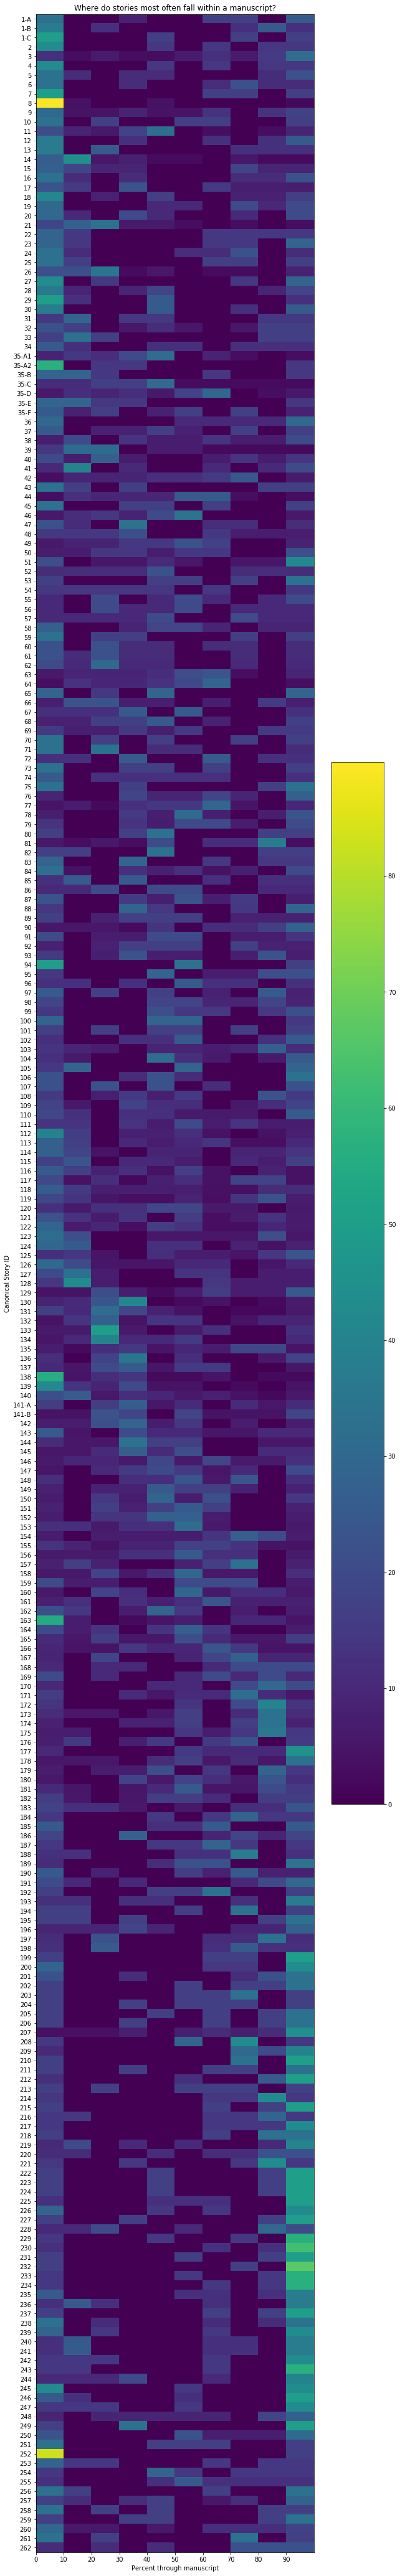

In [150]:
plt.figure(figsize=(10, 75))
plt.pcolor(df_sl)
plt.yticks(np.arange(0.5, len(df_sl.index), 1), [reverse_id_mapper[x] for x in df_sl.index])
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, df_sl.shape[1], 1), range(0, 100, 10))
plt.ylabel('Canonical Story ID')
plt.xlabel('Percent through manuscript')
plt.title('Where do stories most often fall within a manuscript?')
plt.colorbar()
plt.savefig(os.path.join(PLOT_DIR, 'story-placement.png'))
None